In [3]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2


In [4]:
from cods.od.data import MSCOCODataset
from cods.od.models import YOLOModel, DETRModel
import logging
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "1"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = True  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio, shuffle=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
model = DETRModel(model_name="detr_resnet50", pretrained=True, device="cuda:0")
#model = YOLOModel(model_name="yolov8x.pt", pretrained=True, device="cpu")


print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


In [5]:
preds_cal = model.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,  # TODO: make this a default for COCO
    shuffle=False,
    force_recompute=False,  # False,
    deletion_method="nms",
)
preds_val = model.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,  # False,
    deletion_method="nms",
)

# Filter the preds_cal and preds_val with confidence below 0.001


def filter_preds(preds, confidence_threshold=0.001):
    filters = [
        conf > confidence_threshold
        if (conf > confidence_threshold).any()
        else conf.argmin(0)[None]
        for conf in preds.confidences
    ]
    preds.pred_boxes = [pbs[f] for pbs, f in zip(preds.pred_boxes, filters)]
    preds.pred_cls = [pcs[f] for pcs, f in zip(preds.pred_cls, filters)]
    preds.confidences = [
        conf[f] for conf, f in zip(preds.confidences, filters)
    ]
    return preds


preds_cal = filter_preds(preds_cal)
preds_val = filter_preds(preds_val)

Predictions already exist, loading them...
Predictions already exist, loading them...


In [6]:
from cods.od.utils import match_predictions_to_true_boxes

# Avant
1.05 s ± 56.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [75]:
matching = match_predictions_to_true_boxes(preds_cal,"hausdorff", class_factor=None)
for i in range(3):  
    print(f"Matching = {matching[i]}, len={len(matching[i])}")

Matching = [[70], [10], [0], [70], [10], [10], [6], [66], [10], [70], [2], [30], [10], [70], [10], [10], [70], [10], [7]], len=19
Matching = [[12], [22], [12], [16], [24], [16], [12], [24], [16], [16], [16], [12], [16], [12]], len=14
Matching = [[0], [2], [1], [3], [2], [44], [6]], len=7


In [70]:
%%timeit 
match_predictions_to_true_boxes(preds_cal,"hausdorff", class_factor=None)

4.41 s ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
%lprun -f match_predictions_to_true_boxes match_predictions_to_true_boxes(preds_cal,"hausdorff", class_factor=None)

Timer unit: 1e-09 s

Total time: 5.07102 s
File: /home/leo.andeol/envs/cods_13/cods/cods/od/utils.py
Function: match_predictions_to_true_boxes at line 189

Line #      Hits         Time  Per Hit   % Time  Line Contents
   189                                           def match_predictions_to_true_boxes(
   190                                               preds,
   191                                               distance_function,
   192                                               overload_confidence_threshold=None,
   193                                               verbose=False,
   194                                               hungarian=False,
   195                                               idx=None,
   196                                               class_factor: float = 5,
   197                                           ) -> None:
   198                                               """Matching predictions to true boxes. Done in place, modifies the preds object.""

# Après

In [78]:
matching = match_predictions_to_true_boxes(preds_cal,"hausdorff")
for i in range(3):  
    print(f"Matching = {matching[i]}, len={len(matching[i])}")

Matching = [[70], [10], [0], [70], [10], [10], [6], [66], [10], [70], [2], [30], [10], [70], [10], [10], [70], [10], [7]], len=19
Matching = [[12], [22], [12], [16], [24], [16], [12], [24], [16], [16], [16], [12], [16], [12]], len=14
Matching = [[0], [2], [1], [3], [2], [44], [6]], len=7


In [79]:
%%timeit 
match_predictions_to_true_boxes(preds_cal,"hausdorff")

69.8 ms ± 65 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
%lprun -f match_predictions_to_true_boxes match_predictions_to_true_boxes(preds_cal,"hausdorff")

Timer unit: 1e-09 s

Total time: 0.0742312 s
File: /home/leo.andeol/envs/cods_13/cods/cods/od/utils.py
Function: match_predictions_to_true_boxes at line 189

Line #      Hits         Time  Per Hit   % Time  Line Contents
   189                                           def match_predictions_to_true_boxes(
   190                                               preds,
   191                                               distance_function,
   192                                               overload_confidence_threshold=None,
   193                                               verbose=False,
   194                                               hungarian=False,
   195                                               idx=None,
   196                                               class_factor: float = 5,
   197                                           ) -> None:
   198                                               """Matching predictions to true boxes. Done in place, modifies the preds object.

# Tests

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
from cods.od.utils import assymetric_hausdorff_distance, assymetric_hausdorff_distance_old

In [59]:
idx = 11

In [60]:
tbs = preds_cal.true_boxes[idx].clone()
pbs = preds_cal.pred_boxes[idx].clone()

In [61]:
matching1 = []
distances1 = np.zeros((len(tbs), len(pbs)))
true_boxes = tbs
pred_boxes = pbs
for i, true_box in enumerate(true_boxes):
    distances = []
    for j, pred_box in enumerate(pred_boxes):
        dist = assymetric_hausdorff_distance_old(true_box, pred_box)
        dist = (
            dist.cpu().numpy()
            if isinstance(dist, torch.Tensor)
            else dist
        )
        distances.append(dist)  # .cpu().numpy())
        distances1[i, j] = dist
    
    matching1.append([np.argmin(distances)])  

In [62]:
true_boxes = tbs
pred_boxes = pbs

distances2 = assymetric_hausdorff_distance(true_boxes, pred_boxes)
matching2 = torch.argmin(distances2, dim=1).cpu().numpy().reshape(-1, 1).tolist()

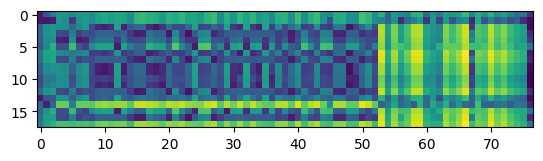

In [63]:
plt.imshow(distances1)

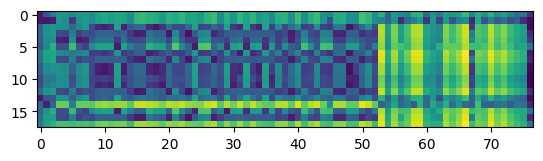

In [64]:
plt.imshow(distances2.cpu().numpy())

In [65]:
[print(x,y) for x,y in zip(matching1, matching2)];

[0] [0]
[76] [76]
[76] [76]
[23] [23]
[6] [6]
[24] [24]
[48] [48]
[23] [23]
[76] [76]
[76] [76]
[76] [76]
[76] [76]
[23] [23]
[76] [76]
[1] [1]
[29] [29]
[23] [23]
[76] [76]
